In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
import numpy as np
import os
import PIL
import time
import matplotlib.pyplot as plt

C:\Users\NEW\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\NEW\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\NEW\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\NEW\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type

In [75]:
plt.rcParams['figure.figsize'] = ['50','50']

In [165]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.fashion_mnist.load_data()

In [166]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x = np.pad(train_x, ((0,0), (2,2), (2,2), (0,0)), 'constant')

test_x = test_x.reshape(test_x.shape[0], 28, 28, 1).astype('float32')
test_x = np.pad(test_x, ((0,0), (2,2), (2,2), (0,0)), 'constant')

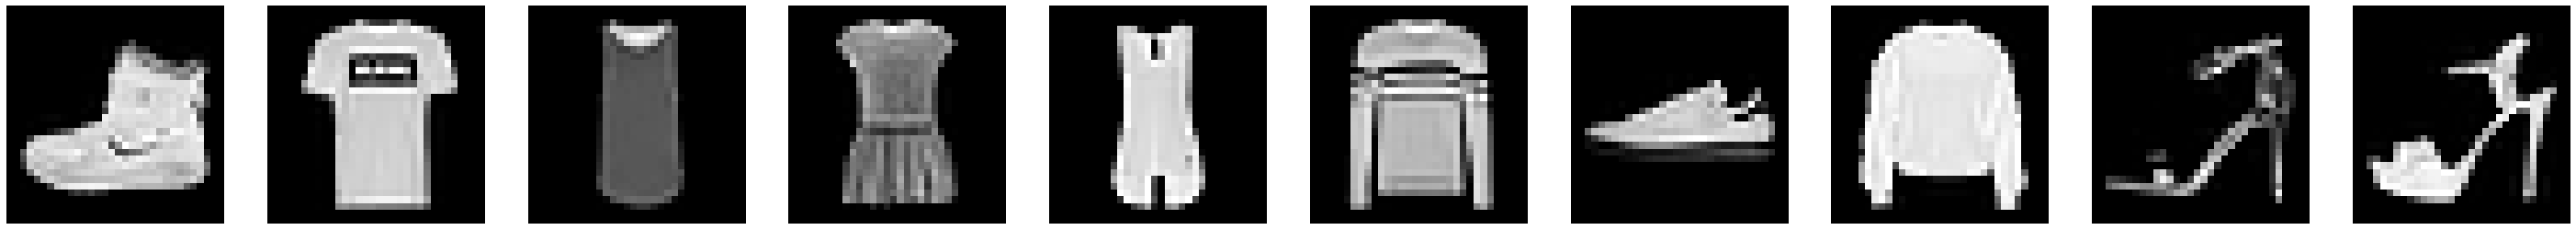

In [167]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_x[i].reshape(32, 32), cmap='gray')
    plt.axis('off')
plt.show()

[[[[ 4.4679565 ]
   [ 0.        ]
   [15.677544  ]
   ...
   [10.201496  ]
   [ 5.968274  ]
   [ 5.491925  ]]

  [[ 3.5707245 ]
   [ 0.        ]
   [13.816778  ]
   ...
   [ 9.478107  ]
   [ 7.101521  ]
   [ 5.7167845 ]]

  [[ 5.0053077 ]
   [12.061583  ]
   [12.341292  ]
   ...
   [ 0.        ]
   [15.986395  ]
   [ 7.5031447 ]]

  ...

  [[25.584131  ]
   [13.22302   ]
   [ 4.3078656 ]
   ...
   [ 7.970081  ]
   [11.030884  ]
   [14.544209  ]]

  [[ 7.786178  ]
   [16.514603  ]
   [ 0.        ]
   ...
   [15.496659  ]
   [ 0.4316234 ]
   [ 1.6812778 ]]

  [[ 0.        ]
   [21.008986  ]
   [12.644307  ]
   ...
   [ 3.5277271 ]
   [ 3.2277522 ]
   [ 7.114918  ]]]


 [[[12.085121  ]
   [ 8.169525  ]
   [19.906824  ]
   ...
   [ 5.060965  ]
   [ 3.473784  ]
   [13.833944  ]]

  [[ 0.        ]
   [13.767291  ]
   [12.297296  ]
   ...
   [30.066221  ]
   [12.494874  ]
   [10.934873  ]]

  [[ 0.        ]
   [14.51128   ]
   [ 0.        ]
   ...
   [ 9.40653   ]
   [ 2.6074276 ]
   [17.3643

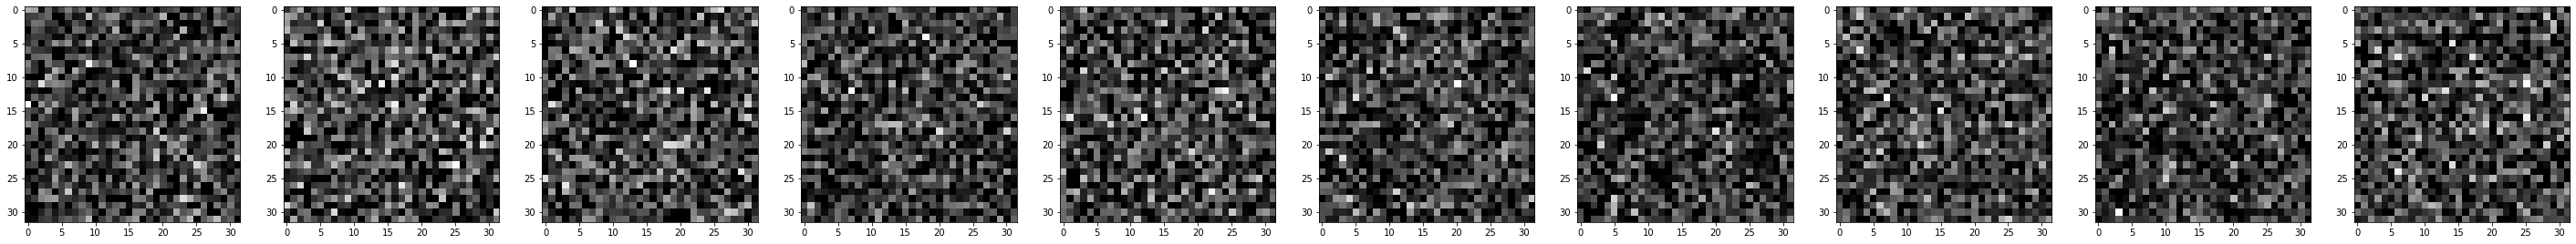

In [172]:
#add noise to train and test images
noise_train = train_x.copy()
noise_test = test_x.copy()

for i in range(train_x.shape[0]):
    #add noise to train set
    poisson_noise = np.random.normal(10, 10, noise_train[i].shape)
    noise_train[i] += poisson_noise
    #normalize the noise_train
    noise_train[i] = np.clip(noise_train[i], 0, 255)

for i in range(test_x.shape[0]):
    #add noise to train set
    poisson_noise = np.random.normal(10, 10, noise_test[i].shape)
    noise_test[i] += poisson_noise
    #normalize the noise_train
    noise_test[i] = np.clip(noise_test[i], 0, 255)

print(noise_train)
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(noise_test[i].reshape(32, 32), cmap='gray')

In [173]:
buffer = 60000
bsize = 256

In [174]:
noise_train = (noise_train - 127.5)/127.5
train_x = (train_x - 127.5)/127.5


In [175]:
noise_test = (noise_test - 127.5)/127.5
test_x = (test_x - 127.5)/127.5

In [176]:
train_x = tf.data.Dataset.from_tensor_slices((train_x, noise_train)).shuffle(buffer).batch(bsize)
test_x = tf.data.Dataset.from_tensor_slices((test_x, noise_test)).batch(bsize)

In [177]:
from tensorflow.keras.layers import Conv2D, ReLU
from tensorflow.keras import Model

#downsampling and upsampling functions
def downsampling(mask, size, normalise=True):
    model = Sequential()
    model.add(Conv2D(mask, size, strides=2, padding='same', use_bias=False))
    
    if normalise:
        model.add(BatchNormalization())
    
    model.add(LeakyReLU())
    return model

def upsampling(mask, size, dropout=False):
    model = Sequential()
    model.add(Conv2DTranspose(mask, size, strides=2, padding='same', use_bias=False))
    model.add(BatchNormalization())
    
    if dropout:
        model.add(tf.keras.layers.Dropout(0.5))
    model.add(ReLU())
    return model

In [178]:
#Modififed U-net generator
def generator():
    values = tf.keras.layers.Input(shape=[32, 32, 1])
    
    #setting up 5 down sampling layers in the CNN model
    y_value = 4
    dstack = [downsampling(16, y_value, False), downsampling(32, y_value)]
    for i in range(3):
        dstack.append(downsampling(64, y_value))
    
    #setting 4 up sampling layers in CNN model
    ustack = [upsampling(64, y_value, True), upsampling(64, y_value, True),
              upsampling(32, y_value), upsampling(16, y_value)]
    
    final_layer = Conv2DTranspose(1, 4, strides = 2, padding='same', activation='tanh')
    
    value = values
    skip_values = []
    
    #Downsampling through the model
    for d in dstack:
        value = d(value)
        skip_values.append(value)
    
    skip_values = reversed(skip_values[:-1])
    
    #Upsampling and creating skip connects from the bottom layer to the root
    for up, sp in zip(ustack, skip_values):
        value = up(value)
        value = tf.keras.layers.Concatenate()([value, sp])
    
    value = final_layer(value)
    return Model(inputs = values, outputs=value)


In [179]:
generate = generator()